Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2021/2022
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Logistička regresija

*Verzija: 1.0 
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2021 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **7. studenog 2021. u 23:59h**

------------------------------

### Upute

Ova laboratorijska vježba sastoji se od četiri zadatka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [72]:
# Učitaj osnovne biblioteke...
import sklearn
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [73]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

### 1. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

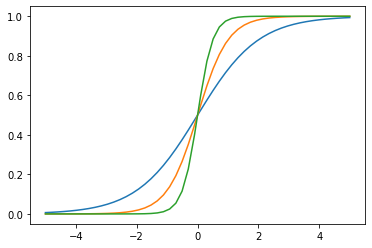

In [171]:
# Vaš kôd ovdje
def sigm(x, alpha):
    return 1/(1+np.exp(-alpha*x))

x = linspace(-5, 5)
plt.plot(x, sigm(x, alpha = 1.0))
plt.plot(x, sigm(x, alpha = 2.0))
plt.plot(x, sigm(x, alpha = 4.0))
plt.show()

**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela? 
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b) 

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [172]:
from numpy import linalg
from sklearn.preprocessing import PolynomialFeatures

def lr_h(x, w):
    if(len(x) == 2):
        return sigm(np.dot(x,w[1:]) + w[0], 1)
    return sigm(np.dot(x, w), 1)
    
def cross_entropy_error(X, y, w):
    N, n = X.shape
    error = 0
    for i in range (0, N):
        h = lr_h(X[i], w)
        error += -y[i] * np.log(h) - (1-y[i])*np.log(1-h) 
    return error/N

def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
    
    # Vaš kôd ovdje
    N, n = X.shape
    w = np.zeros(n+1)
    w_history = []
    
    poly = PolynomialFeatures(1)
    phi = poly.fit_transform(X)
    
    iter = 0
    while(iter < max_iter):
        dw = np.zeros(n+1)
        for i in range(0, N):
            h = lr_h(phi[i], w)
            dw -= (h - y[i]) * phi[i]        
        w_new = w + eta * dw
        if(abs(cross_entropy_error(phi,y,w) - cross_entropy_error(phi,y,w_new)) < epsilon):
            print('Postignut uvjet izlaska na iteraciji',iter,'Konačna pogreška:', cross_entropy_error(phi,y,w))
            if(trace):
                return w, w_history
            else:
                return w
        w = w_new
        if(trace):
            w_history.append(w)
        iter += 1
    print('Prošao svih', max_iter, 'iteracija. Konačna pogreška:', cross_entropy_error(phi,y,w))
    if(trace):
        return w, w_history
    else:
        return w

### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije. 

**NB:** Pripazite da modelu date dovoljan broj iteracija.

In [173]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

Postignut uvjet izlaska na iteraciji 946 Konačna pogreška: 0.13531865860896639


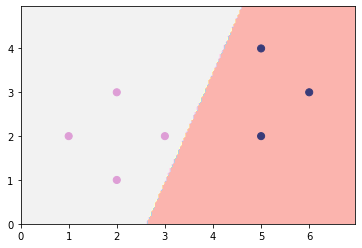

In [174]:
# Vaš kôd ovdje
w = lr_train(seven_X, seven_y)
plot_2d_clf_problem(seven_X, seven_y, lambda x: lr_h(x, w) >= 0.5)

**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

In [175]:
from sklearn.metrics import zero_one_loss

Postignut uvjet izlaska na iteraciji 946 Konačna pogreška: 0.13531865860896639


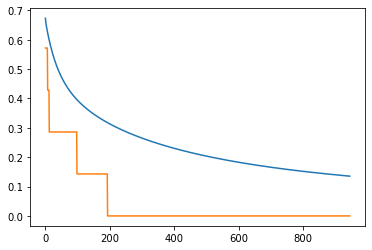

Postignut uvjet izlaska na iteraciji 1141 Konačna pogreška: 0.18852633850840775
Postignut uvjet izlaska na iteraciji 946 Konačna pogreška: 0.13531865860896639
Postignut uvjet izlaska na iteraciji 510 Konačna pogreška: 0.06389964580855939
Postignut uvjet izlaska na iteraciji 377 Konačna pogreška: 0.04614444996249478


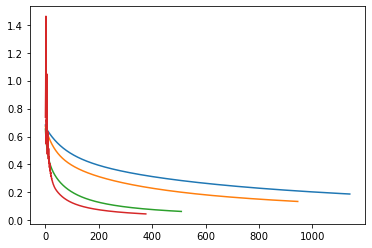

In [176]:
# Vaš kôd ovdje
w_final, w_history = lr_train(seven_X, seven_y, trace=True)
n = len(w_history)
N = len(seven_X)
c_e_error = np.zeros(n)
z_o_error = np.zeros(n)
i = 0
for w in w_history:
    c_e_error[i] = cross_entropy_error(seven_X, seven_y, w)
    
    h = np.zeros(N)
    for j in range(0, N):
        h[j] = lr_h(seven_X[j], w) >= 0.5
    z_o_error[i] = zero_one_loss(seven_y, h)
    i += 1
n = np.arange(0, n, 1)
plt.plot(n, c_e_error)
plt.plot(n, z_o_error)
plt.show()

etas = [0.005, 0.01, 0.05, 0.1]
for eta in etas:
    w_final, w_history = lr_train(seven_X, seven_y, eta=eta, trace=True)
    n = len(w_history)
    c_e_error = np.zeros(n)
    i = 0
    for w in w_history:
        c_e_error[i] = cross_entropy_error(seven_X, seven_y, w)
        i += 1
    n = np.arange(0, n, 1)
    plt.plot(n, c_e_error)
plt.show()


**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

w0= [46.26968486] w= [[-14.80304235   4.33454163]]


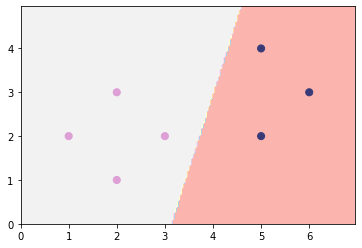

In [177]:
from sklearn.linear_model import LogisticRegression

# Vaš kôd ovdje
clf = LogisticRegression(penalty='none', max_iter = 2000)
clf.fit(seven_X, seven_y)
print('w0=',clf.intercept_, 'w=',clf.coef_)
plot_2d_clf_problem(seven_X, seven_y, clf.predict)

### 2. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier`. Prikažite granicu između klasa.

In [178]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

Postignut uvjet izlaska na iteraciji 842 Konačna pogreška: 0.12606992417165994


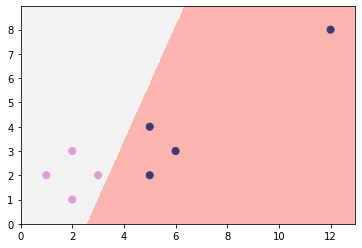

In [179]:
# Vaš kôd ovdje
w = lr_train(outlier_X, outlier_y)
plot_2d_clf_problem(outlier_X, outlier_y, lambda x: lr_h(x, w) >= 0.5)

**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

Postignut uvjet izlaska na iteraciji 946 Konačna pogreška: 0.13531865860896639


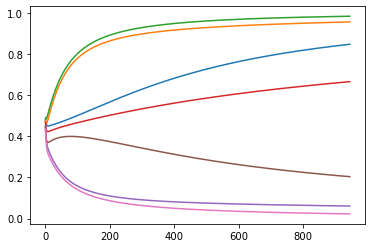

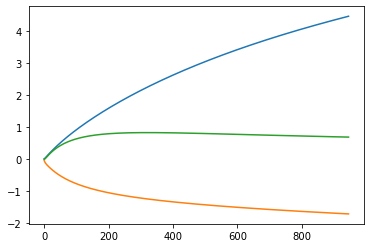

In [181]:
# Vaš kôd ovdje
w_final, w_history = lr_train(seven_X, seven_y, trace=True)
n = len(w_history)
N = len(seven_X)
h = []
for w in w_history:
    h_values = np.zeros(N)
    for i in range(0, N):
        h_values[i] = lr_h(seven_X[i], w)
    h.append(h_values)
x = np.arange(0, n, 1)
plt.plot(x, h)
plt.show()

plt.plot(x, w_history)
plt.show()

### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep`.

In [182]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

Postignut uvjet izlaska na iteraciji 453 Konačna pogreška: 0.4064524196459286


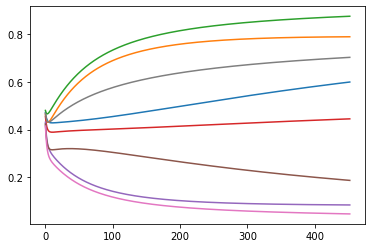

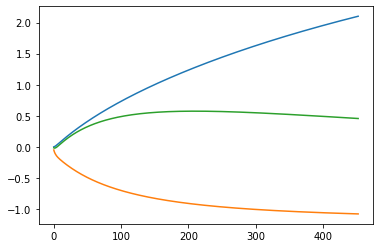

In [183]:
# Vaš kôd ovdje
w_final, w_history = lr_train(unsep_X, unsep_y, trace=True)
n = len(w_history)
N = len(unsep_X)
h = []
for w in w_history:
    h_values = np.zeros(N)
    for i in range(0, N):
        h_values[i] = lr_h(unsep_X[i], w)
    h.append(h_values)
x = np.arange(0, n, 1)
plt.plot(x, h)
plt.show()

plt.plot(x, w_history)
plt.show()

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 3. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

In [15]:
from numpy.linalg import norm

In [16]:
# Vaš kôd ovdje

**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 4. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

In [17]:
from sklearn.preprocessing import PolynomialFeatures

#plot_2d_clf_problem(X, y, lambda x : model.predict(poly.transform(x))

In [18]:
from sklearn.datasets import make_classification

# Vaš kôd ovdje

**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?